In [0]:
import keras
from keras.datasets import boston_housing

In [0]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [13]:
# Taking a look at the data
train_data.shape

(404, 13)

In [14]:
test_data.shape

(102, 13)

We have 404 training examples and 102 test examples


In [15]:
train_data[0]
# This line will show that the features are scaled differently

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

Preparing the data

In [0]:
# Normalizing the data
# Here we're subtracting the mean of each feature then dividing by the standard deviation

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std 

test_data -= mean
test_data /= std

In [0]:
from keras import models
from keras import layers

def buildModel():
  model = models.Sequential()
  model.add(layers.Dense(64, activation="relu", input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation ='relu'))
  # The last layer doesn't have an activation function because it's a regression problem
  model.add(layers.Dense(1))

  # selecting the optimizer, loss, and metric
  model.compile(optimizer="rmsprop", loss ="mse", metrics = ["mae"])

  return(model)


Using K-fold validation to create a validation set because our training set is really small

In [18]:
import numpy as np

k=4 #we want k-folds
num_val_samples = len(train_data) // k  #size of a fold
num_epochs = 100  #number of times we iterate over the training data
all_scores = []  #array that holds the scores of each fold

for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
        # Build the Keras model (already compiled)
    model = buildModel()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [19]:
all_scores

[2.255988359451294, 2.7374966144561768, 2.9329118728637695, 2.2969107627868652]

In [20]:
np.mean(all_scores)

2.5558269023895264

In [21]:
# Updating the training loop to record the performance at each epoch using history
# I'm also increasing the number of epochs to try and increase accuracy


num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = buildModel()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [0]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

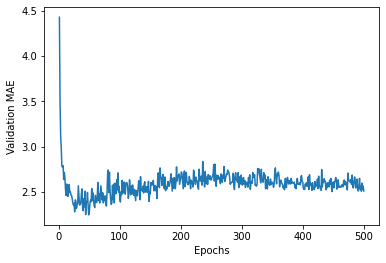

In [23]:

import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

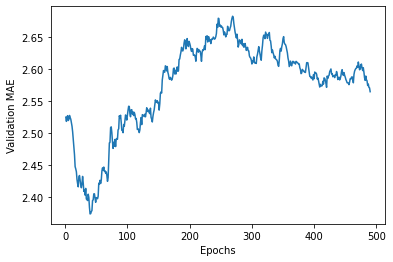

In [24]:

def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [26]:
# Get a fresh, compiled model.
model = buildModel()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 210us/step


In [27]:
# We are missing about $2800
#Simply multiply this score by 1000
test_mae_score

2.857938051223755